#Import

In [ ]:
import os
import re
import cv2
import glob
import keras
import numpy as np
import pandas as pd
from time import time
import tensorflow as tf
from scipy import signal
from skimage import color
from skimage.io import imread
from keras import backend as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from IPython.display import Image
from skimage.transform import resize
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Input,Model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

%matplotlib inline
tf.__version__

'2.8.0'

#Carga y procesamiento de datos

Se cargan las carpetas con imágenes desde el repositorio en github

In [ ]:
!git clone https://github.com/Kadyha/Brain_Tumor_Detection_MRI.git

Cloning into 'Brain_Tumor_Detection_MRI'...
remote: Enumerating objects: 3238, done.
remote: Counting objects: 100% (963/963), done.
remote: Compressing objects: 100% (922/922), done.
remote: Total 3238 (delta 26), reused 952 (delta 26), pack-reused 2275
Receiving objects: 100% (3238/3238), 63.52 MiB | 22.54 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Checking out files: 100% (3061/3061), done.


Se cargan las imágenes de cada carpeta en un vector

In [ ]:
noTumorImages = [cv2.imread(file).mean(axis=2) for file in glob.glob("Brain_Tumor_Detection_MRI/data/no/*.jpg")]
yesTumorImages = [cv2.imread(file).mean(axis=2) for file in glob.glob("Brain_Tumor_Detection_MRI/data/yes/*.jpg")]

In [ ]:
len (noTumorImages), len (yesTumorImages)

(1500, 1500)

Todas las imágenes leidas son como la que se muestra a continuación

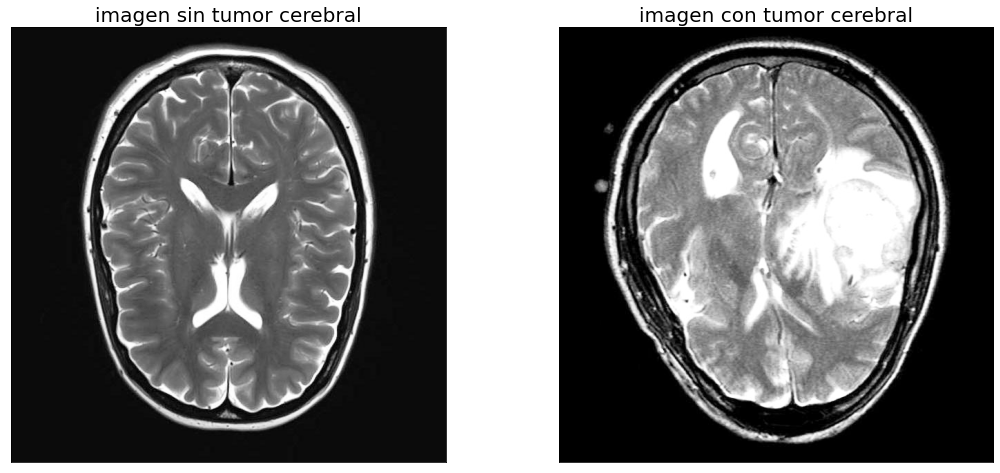

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(121), plt.xticks([]), plt.yticks([])
plt.title("imagen sin tumor cerebral",fontsize= 20)
plt.imshow(imread("Brain_Tumor_Detection_MRI/data/no/No12.jpg").mean(axis=2), 
           cmap=plt.cm.Greys_r)
plt.subplot(122), plt.xticks([]), plt.yticks([])
plt.title("imagen con tumor cerebral",fontsize= 20)
plt.imshow(imread("Brain_Tumor_Detection_MRI/data/yes/y244.jpg").mean(axis=2), 
           cmap=plt.cm.Greys_r)

#Transformación de las imágenes

Se les da a todas las imágenes un tamaño de (224, 224, 3) y se normalizan los pixeles

In [ ]:
def get_img(images):
  for i in range(len(images)):
    images[i] = resize(images[i], output_shape=(224,224,3))
    images[i] = ((images[i]-np.min(images[i]))/(np.max(images[i])-np.min(images[i]))*255).astype(int)
  return images

In [ ]:
noTumorImages = get_img(noTumorImages)
yesTumorImages = get_img(yesTumorImages)

In [ ]:
len (noTumorImages), noTumorImages[23].shape

(1500, (224, 224, 3))

(224, 224, 3)


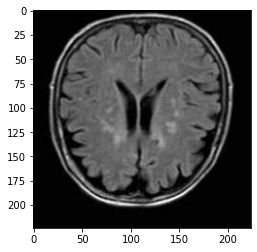

In [ ]:
print (noTumorImages[23].shape)
plt.imshow(noTumorImages[23])

#Creación de las variables X e y

Las variables X e y, corresponden a la matriz de datos y el vector de etiquetas respectivamente

In [ ]:
X = np.array(noTumorImages + yesTumorImages, dtype=np.uint8)
y = np.concatenate((np.zeros(len(noTumorImages)), np.ones(len(yesTumorImages))), axis=None)
X.shape, y.shape

((3000, 224, 224, 3), (3000,))

#División los datos para entrenamiento, pruebas y validación

In [ ]:
XTrainTest, XVal, yTrainTest, yVal = train_test_split(X,y,test_size=0.1)
XTrain, XTest, yTrain, yTest = train_test_split(XTrainTest,yTrainTest,test_size=0.2)

print('Tamaño datos de Validación:    ', XVal.shape, yVal.shape)
print('Tamaño datos de entrenamiento: ', XTrain.shape, yTrain.shape)
print('Tamaño datos de prueba:        ', XTest.shape, yTest.shape)
print("\ndistribución de las clases de entrenamiento")
print(pd.Series(yTrain).value_counts())
print("\ndistribución de las clases de prueba")
print(pd.Series(yTest).value_counts())

Tamaño datos de Validación:     (300, 224, 224, 3) (300,)
Tamaño datos de entrenamiento:  (2160, 224, 224, 3) (2160,)
Tamaño datos de prueba:         (540, 224, 224, 3) (540,)

distribución de las clases de entrenamiento
0.0    1084
1.0    1076
dtype: int64

distribución de las clases de prueba
0.0    273
1.0    267
dtype: int64


#Modelo

###Creación del modelo

In [ ]:

def get_model(compile=True):
    inputs = tf.keras.Input(shape=(224,224,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(2, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model


In [ ]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 214, 214, 96)      34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 107, 107, 96)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 60)        697020    
                                                                 
 flatten (Flatten)           (None, 564540)            0         
                                                                 
 dropout (Dropout)           (None, 564540)            0         
                                                             

###Entrenamiento del modelo

Se conecta con google drive para guardar los modelos entrenados. 

*   Los modelos se guardan en "Mi unidad" de Google Drive, en una carpeta que será llamada models
*   Se guarda el mejor modelo obtenido entre todas las épocas de entrenamiento




In [ ]:
from google.colab import drive
import os
saveModel = False
try:
  drive.mount('/content/drive')
except:
  print("Si quiere guardar los modelos creados debe aceptar el permiso para para ver, editar, crear y eliminar archivos en su google drive")
try:
  if os.path.isdir('./drive/MyDrive/models'):
    print("\nLos modelos se guardarán en su directorio models")
    saveModel = True
  else:
    os.mkdir('./drive/MyDrive/models')
    print("\nLos modelos se guardarán en un directorio llamado models en su unidad de drive")
    saveModel = True
except:
    saveModel = False
    print("\nNo se tiene permiso para acceder a drive")

Mounted at /content/drive

Los modelos se guardarán en su directorio models


Se crea la dirección en la que se guardarán los modelos

In [ ]:
RES_DIR = './drive/MyDrive/models/'
FILE_P = '%sBrain_tumor_detector%d'
FILE_PATH = ''+ FILE_P + '.h5'
if saveModel == False:
  print('No se guardarán modelos ya que no se acepto el permiso para para ver, editar, crear y eliminar archivos en su google drive')

Se crea la función para el entrenamiento

In [ ]:
def train(model, batch_size, epochs, numModel=0, model_name=""):
  callback = ModelCheckpoint((FILE_PATH % (RES_DIR, numModel)), monitor='loss', verbose=1,
            save_best_only=True, mode='auto', save_freq=int((len(XTrain)/batch_size)+1))
  model.fit(XTrain, yTrain, epochs=epochs, callbacks=[callback],
            batch_size=batch_size,
            validation_data=(XTest, yTest))
  metrics = model.evaluate(XTest, yTest)
  return {k:v for k,v in zip (model.metrics_names, metrics)}

Entrenamiento del modelo

In [ ]:
train(model, batch_size=16, epochs=5, model_name="Brain_tumor_detector")

Epoch 1/5
135/135 [==============================] - 2797s 21s/step - loss: 26.8497 - accuracy: 0.6130 - val_loss: 0.6556 - val_accuracy: 0.6389
Epoch 2/5

Epoch 2: loss improved from inf to 0.64052, saving model to ./drive/MyDrive/models/Brain_tumor_detector0.h5
135/135 [==============================] - 2934s 22s/step - loss: 0.6428 - accuracy: 0.6167 - val_loss: 0.6036 - val_accuracy: 0.6389
Epoch 3/5
  1/135 [..............................] - ETA: 49:46 - loss: 0.6753 - accuracy: 0.6250
Epoch 3: loss did not improve from 0.64052
135/135 [==============================] - 2922s 22s/step - loss: 0.5840 - accuracy: 0.6560 - val_loss: 0.6094 - val_accuracy: 0.6537
Epoch 4/5
  2/135 [..............................] - ETA: 42:55 - loss: 0.5815 - accuracy: 0.6875
Epoch 4: loss improved from 0.64052 to 0.55934, saving model to ./drive/MyDrive/models/Brain_tumor_detector0.h5
135/135 [==============================] - 2922s 22s/step - loss: 0.5890 - accuracy: 0.6583 - val_loss: 0.5612 - val_

{'accuracy': 0.699999988079071, 'loss': 0.5561938285827637}

###Evaluación del modelo

####Perdida y exactitud

In [ ]:
test_loss, test_acc = model.evaluate(XTest, yTest)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

17/17 [==============================] - 174s 10s/step - loss: 0.5562 - accuracy: 0.7000
Test loss: 0.5561938285827637
Test accuracy: 0.699999988079071


In [ ]:
val_loss, val_acc = model.evaluate(XVal, yVal)
print('Val loss:', val_loss)
print('Val accuracy:', val_acc)

####Predicciones

In [ ]:
predictions = model.predict(XVal)

Predicción de un grupo de imágenes

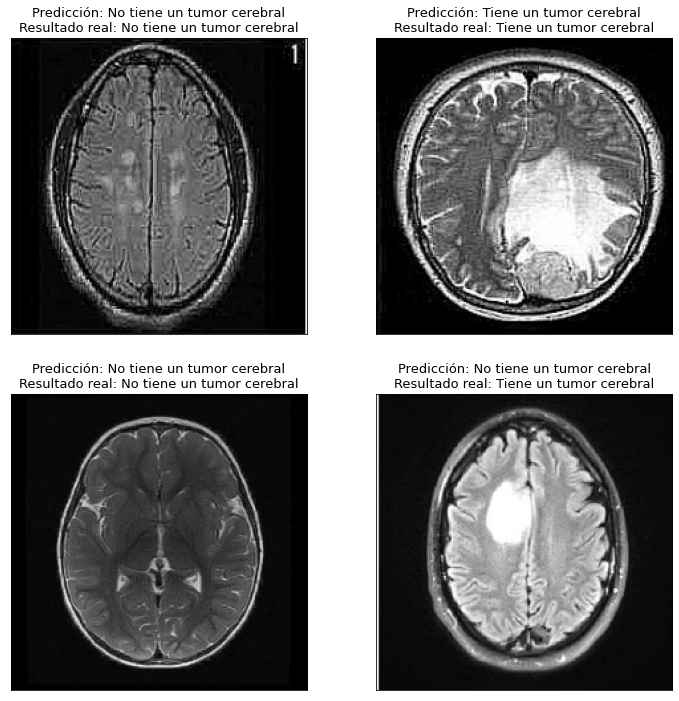

In [ ]:
rows = 2  #Número de imágenes en las filas
columns = 2  #Número de imágenes en las columnas
fig = plt.figure(figsize=(12, 12))
for i in range(1, columns*rows +1):
  nimg = np.random.randint(len(XVal)) # Número de la imagen que se desea predecir
  if np.argmax(predictions[nimg]) == 0:
    title = "Predicción: No tiene un tumor cerebral"
  else:
    title = "Predicción: Tiene un tumor cerebral"
  if yVal[nimg] == 0:
    subtitle = "Resultado real: No tiene un tumor cerebral"
  else:
    subtitle = "Resultado real: Tiene un tumor cerebral"
  text = (title+"\n"+subtitle)
  fig.add_subplot(rows, columns, i)
  plt.xticks([]), plt.yticks([])
  plt.title(text,fontsize= 13)
  plt.imshow(XVal[nimg], cmap=plt.cm.Greys_r)
plt.show()

Predicción individual

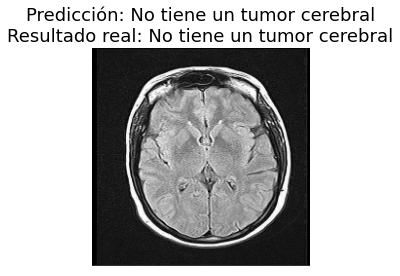

In [ ]:
nimg = np.random.randint(len(XVal)) # Número de la imagen que se desea predecir
#nimg = input()
if np.argmax(predictions[nimg]) == 0:
  title = "Predicción: No tiene un tumor cerebral"
else:
  title = "Predicción: Tiene un tumor cerebral"
if yVal[nimg] == 0:
  subtitle = "Resultado real: No tiene un tumor cerebral"
else:
  subtitle = "Resultado real: Tiene un tumor cerebral"
text = (title+"\n"+subtitle)
plt.xticks([]), plt.yticks([])
plt.title(text,fontsize= 18)
plt.imshow(XVal[nimg], cmap=plt.cm.Greys_r)